In [ ]:
! pip install yfinance

In [ ]:
# Load DataFrame

import glob
import math
import pandas as pd
import yfinance as yf

# 1) Load all CSV files into one DataFrame
csv_files = glob.glob("/workspaces/codespaces-jupyter/data/*.csv")  # update path if needed
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)

# 2) Parse ticker → expiration, option type, strike
def parse_ticker(ticker):
    core       = ticker.split("O:SPXW")[1]      # e.g. "240102C02200000"
    exp_str    = core[:6]                       # "YYMMDD"
    opt_char   = core[6]                        # 'C' or 'P'
    strike     = int(core[7:]) / 1000.0         # e.g. "02200000" → 2200.0
    expiration = pd.to_datetime(exp_str, format="%y%m%d").date()
    option_type= "call" if opt_char=="C" else "put"
    return expiration, option_type, strike

df[["expiration","option_type","strike"]] = (
    df["ticker"]
      .apply(parse_ticker)
      .apply(pd.Series)
)

# 3) Convert nanosecond timestamp → trade date
df["date"] = pd.to_datetime(df["window_start"], unit="ns").dt.date

# 4) Fetch SPX spot (^GSPC) and 13-week T-bill yield (^IRX)
start, end = df["date"].min(), df["date"].max() + pd.Timedelta(days=1)

# SPX index close
spx = (yf.Ticker("^GSPC")
         .history(start=start, end=end)["Close"]
         .rename("S")
         .reset_index())
spx["Date"] = spx["Date"].dt.date
df = df.merge(spx[["Date","S"]], left_on="date", right_on="Date", how="left").drop(columns=["Date"])

# IRX yield → decimal r
irx = (yf.Ticker("^IRX")
         .history(start=start, end=end)["Close"]
         .rename("r")
         .reset_index())
irx["Date"] = irx["Date"].dt.date
irx["r"] = irx["r"] / 100.0
df = df.merge(irx[["Date","r"]], left_on="date", right_on="Date", how="left").drop(columns=["Date"])

# 5) Compute time to maturity T in years
df["T"] = (pd.to_datetime(df["expiration"]) - pd.to_datetime(df["date"])).dt.days / 365.0

# Preview populated DataFrame
print(df[["ticker","date","expiration","strike","option_type","close","S","r","T"]].head())


In [ ]:
# filter out rows with time to maturity = 0

import pandas as pd

# Load your existing CSV
df = pd.read_csv("/workspaces/codespaces-jupyter/iv data/data_with_iv_inputs.csv")

# Filter out rows where time-to-maturity T is exactly zero
df_nonzero_T = df[df["T"] > 0].copy()

# Save filtered CSV back (overwriting original or to a new file)
df_nonzero_T.to_csv("/workspaces/codespaces-jupyter/iv data/data_with_iv_inputs_filtered.csv", index=False)

print(f"Rows before filter: {len(df)}, after removing T=0 rows: {len(df_nonzero_T)}")


Rows before filter: 2287205, after removing T=0 rows: 2189490


In [8]:
# write the full DataFrame to a CSV
df.to_csv("data_with_iv_inputs.csv", index=False)

In [ ]:
! pip install py_vollib # use vollib for BSM IV calculations

In [ ]:
# BSM IV

import pandas as pd
import numpy as np
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv_bs

# 1) Load your full inputs (make sure this path is correct)
df = pd.read_csv("/workspaces/codespaces-jupyter/iv data/data_with_iv_inputs_filtered.csv")

# 2) Filter out degenerate rows exactly as before
mask = (
    (df["T"]      > 0)      # positive time to maturity
  & (df["S"]      > 0)      # positive spot
  & (df["strike"] > 0)      # positive strike
  & (df["close"]  > 0)      # positive market price
)
df = df.loc[mask].copy()

# 3) Map 'call'/'put' → 'c'/'p'
df["otype_flag"] = df["option_type"].map({"call":"c","put":"p"})

# 4) Compute implied vols
ivs = []
for C, S, K, T, r, flag in zip(
    df["close"], df["S"], df["strike"], df["T"], df["r"], df["otype_flag"]
):
    try:
        iv = iv_bs(C, S, K, T, r, flag)
    except Exception:
        iv = np.nan
    ivs.append(iv)
df["implied_vol"] = ivs

# 5) Write out the enriched IV surface including T, S, r
output_cols = ["ticker","date","strike","option_type","T","S","r","implied_vol"]
df[output_cols].to_csv(
    "/workspaces/codespaces-jupyter/notebooks/implied_vols_pyvollib.csv",
    index=False
)

print(f"Wrote {len(df)} IVs (with T, S, r) to implied_vols_pyvollib.csv")


Wrote 2189490 IVs (with T, S, r) to implied_vols_pyvollib.csv


In [ ]:
! pip install QuantLib-Python # use quantlib for future workflows with other models

In [ ]:
# Monthly Historical Volatility

import pandas as pd
import numpy as np
import yfinance as yf

# 1) Find true option‐data span
df = pd.read_csv(
    '/workspaces/codespaces-jupyter/iv data/data_with_iv_inputs_filtered.csv',
    usecols=['date']
)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
valid = df['date'].dropna()
valid = valid[valid >= '2000-01-01']     # drop junk
start_date, end_date = valid.min(), valid.max()

print(f"Options span: {start_date.date()} → {end_date.date()}")

# 2) Compute fetch_start so that by start_date you have 252 trading days back
window_days = 252
# Approximate 252 trading days ≈ 365 calendar days
buffer_days = int(window_days * 365 / 252)  # ≈ 365
fetch_start = start_date - pd.Timedelta(days=buffer_days)

# 3) Download SPX from fetch_start to end_date
spx = yf.download(
    '^GSPC',
    start=fetch_start.strftime('%Y-%m-%d'),
    end  = end_date   .strftime('%Y-%m-%d'),
    progress=False
)

# 4) Compute daily log returns & rolling vol
spx['log_ret'] = np.log(spx['Close'] / spx['Close'].shift(1))
spx['rolling_vol'] = (
    spx['log_ret']
       .rolling(window=window_days, min_periods=window_days)
       .std()
    * np.sqrt(252)
)

# 5) Resample to month-ends & square → monthly theta
monthly_vol   = spx['rolling_vol'].resample('M').last()
monthly_theta = (monthly_vol**2).loc[start_date:end_date].dropna()

# 6) Inspect: now you should see Jan/Feb 2024
print("\nMonthly θ (variance) within option span:")
print(monthly_theta.head().to_string())
print("...")
print(monthly_theta.tail().to_string())

monthly_theta.to_csv('/workspaces/codespaces-jupyter/monthly_theta.csv', header=True)

In [11]:
# Filter Heston Calibration Features & Split Day

import pandas as pd

# Load your full big CSV
big_df = pd.read_csv('/workspaces/codespaces-jupyter/iv data/data_with_iv_inputs_filtered.csv')

# Filter for the specific day
date_of_interest = '2025-06-18'
df_day = big_df[big_df['date'] == date_of_interest].copy()

# Keep only the columns we need
keep_cols = [
    'strike',
    'T',           # time to expiry (in years)
    'close',       # market price to use for IV calculation
    'option_type', # 'call' or 'put'
    'S',           # spot price
    'r',           # risk-free rate
    # 'q',         # if you have it, otherwise ignore
    # 'expiration',# if you want to keep
    # 'date',      # optional, may want to keep
    # 'volume',    # if you want to filter
]
df_day = df_day[keep_cols]

# (Optional) create 'CALL' boolean (some pipelines want this)
df_day['CALL'] = df_day['option_type'].map({'call': True, 'put': False})

# (Optional) filter out options with T <= 0 or super low price
df_day = df_day[df_day['T'] > 0]
df_day = df_day[df_day['close'] > 0.01]  # remove nearly worthless options

# Preview
print(df_day.head())
print(f"Number of filtered options for {date_of_interest}:", len(df_day))

# Save to a tidy CSV for calibration
df_day.to_csv(f'/workspaces/codespaces-jupyter/daily filtered/calib_options_{"daily_filtered_" + date_of_interest}.csv', index=False)


         strike         T    close option_type            S        r  CALL
1909581  2400.0  0.005479  3601.93        call  5980.870117  0.04223  True
1909582  4310.0  0.005479  1694.69        call  5980.870117  0.04223  True
1909583  4320.0  0.005479  1684.72        call  5980.870117  0.04223  True
1909584  4350.0  0.005479  1639.59        call  5980.870117  0.04223  True
1909585  4420.0  0.005479  1572.79        call  5980.870117  0.04223  True
Number of filtered options for 2025-06-18: 5610


In [ ]:
! pip install numpy pandas matplotlib py_vollib_vectorized scipy


In [1]:
import sys

# Add the folder with your calibration .py files to the Python path
sys.path.append('/workspaces/codespaces-jupyter/heston calibration/tools')


In [2]:
import pandas as pd
import numpy as np
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv

# 1. Load and pre-filter
df = pd.read_csv('/workspaces/codespaces-jupyter/daily filtered/calib_options_daily_filtered_2025-06-18.csv')
S = df['S'].iloc[0]
r = df['r'].iloc[0]
q = 0

if 'volume' in df.columns:
    df = df[df['volume'] > 10]
df = df[(df['T'] > 7/365) & (df['T'] < 180/365)]
df = df[(df['strike'] > 0.8*S) & (df['strike'] < 1.2*S)]
df = df[df['close'] > 0.1]

flags = np.where(df['option_type'] == 'call', 'c', 'p')
market_vol = calculate_iv(df['close'].values, S, df['strike'].values, df['T'].values, r, flags, q,
                         model='black_scholes_merton', return_as='numpy') * 100
mask = (~np.isnan(market_vol)) & (df['T'].values > 0) & (df['close'].values > 0.01)
df = df[mask]
df = df.copy()
df['market_vol'] = market_vol[mask]
df['moneyness'] = df['strike'].values / S

def densified_grid_sample(
        df,
        # --- dense region definitions ---
        atm_lo=0.95, atm_hi=1.05,           # moneyness for ATM window
        short_lo=7,  short_hi=45,           # days-to-expiry window
        # --- bin widths ---
        step_m_atm=0.01,  step_m_far=0.025, # moneyness bin sizes
        step_d_short=5,   step_d_long=20,   # days bin sizes
        min_samples=150                      # want at least this many
):
    """Return a DataFrame of sampled options with ATM/short-dated densification."""
    # Work in days for readability
    df = df.copy()
    df['days'] = (df['T'] * 365).round().astype(int)

    # --- build moneyness edges ---
    edges_m = np.concatenate([
        np.arange(df['moneyness'].min(), atm_lo,   step_m_far),
        np.arange(atm_lo,               atm_hi,   step_m_atm),
        np.arange(atm_hi,               df['moneyness'].max() + step_m_far,
                  step_m_far)
    ])
    # --- build expiry edges (days) ---
    edges_d = np.concatenate([
        np.arange(short_lo,  short_hi,  step_d_short),
        np.arange(short_hi,  df['days'].max() + step_d_long,
                  step_d_long)
    ])

    selected = []
    for i in range(len(edges_d) - 1):
        for j in range(len(edges_m) - 1):
            in_bin = df[
                (df['days'] >= edges_d[i]) & (df['days'] < edges_d[i+1]) &
                (df['moneyness'] >= edges_m[j]) & (df['moneyness'] < edges_m[j+1])
            ]
            if not in_bin.empty:
                # pick most liquid (highest 'close'); could use volume instead
                idx = in_bin['close'].idxmax()
                selected.append(idx)

    sampled = df.loc[list(set(selected))]

    # Ensure we hit the desired size; if not, relax by picking top-priced extras
    if len(sampled) < min_samples:
        shortfall = min_samples - len(sampled)
        extras = (df.drop(sampled.index)
                    .sort_values('close', ascending=False)
                    .head(shortfall))
        sampled = pd.concat([sampled, extras])

    print(f"Sampled {len(sampled)} options "
          f"(dense ATM/short-dated + coarse far/long).")
    return sampled

# ------------------------------------------------------------------
# Call the function
# ------------------------------------------------------------------
df_sampled = densified_grid_sample(df,
                                   atm_lo=0.95, atm_hi=1.05,
                                   short_lo=7,  short_hi=45,
                                   step_m_atm=0.01, step_m_far=0.025,
                                   step_d_short=5, step_d_long=20,
                                   min_samples=150)

print(f"Final sample size: {len(df_sampled)} options")
print(f"Unique moneyness bins: {df_sampled['moneyness'].round(4).nunique()}, "
      f"unique expiry bins: {df_sampled['days'].nunique()}")
# ------------------------------------------------------------------
# 3.  Prepare arrays for calibration
# ------------------------------------------------------------------
strikes     = df_sampled['strike'].to_numpy()
T           = df_sampled['T'     ].to_numpy()
prices      = df_sampled['close' ].to_numpy()
flags       = np.where(df_sampled['option_type'] == 'call', 'c', 'p')
market_vol  = df_sampled['market_vol'].to_numpy()


/home/codespace/.python/current/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [180, 181, 182, 183, 184, 185, 453, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 755, 909, 910, 911, 1273, 1401, 1402, 1403, 1911, 2536, 2987, 3241]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


Sampled 274 options (dense ATM/short-dated + coarse far/long).
Final sample size: 274 options
Unique moneyness bins: 118, unique expiry bins: 31


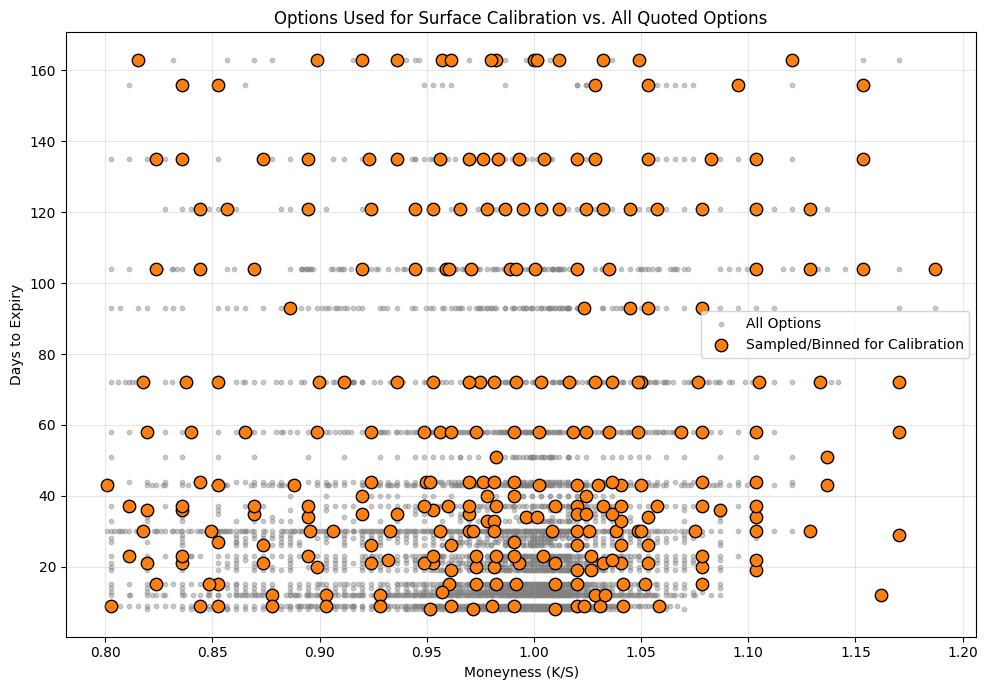

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have df (full DataFrame BEFORE filtering) and df_sampled (after binning)
S = df['S'].iloc[0]
moneyness_all = df['strike'] / S
expiry_all = df['T'] * 365  # in days

moneyness_sampled = df_sampled['strike'] / S
expiry_sampled = df_sampled['T'] * 365

plt.figure(figsize=(10, 7))
plt.scatter(moneyness_all, expiry_all, s=10, c='gray', alpha=0.4, label='All Options')
plt.scatter(moneyness_sampled, expiry_sampled, s=80, c='tab:orange', edgecolor='black', marker='o', label='Sampled/Binned for Calibration')

plt.xlabel('Moneyness (K/S)')
plt.ylabel('Days to Expiry')
plt.title('Options Used for Surface Calibration vs. All Quoted Options')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# ---------------------------------------------------------------
# 3.  Prepare arrays for calibration
# ---------------------------------------------------------------
from Heston_COS_METHOD      import heston_cosine_method
from Levenberg_Marquardt    import levenberg_Marquardt
from Heston_Calibration_Class import Data_Class
from py_vollib_vectorized   import vectorized_implied_volatility as calculate_iv
import numpy as np
import datetime as dt


strikes     = df_sampled['strike' ].to_numpy()
T           = df_sampled['T'      ].to_numpy()
prices      = df_sampled['close'  ].to_numpy()
flags       = np.where(df_sampled['option_type']=='call', 'c', 'p')
market_vol  = df_sampled['market_vol'].to_numpy()

# avoid dimension mismatch

r_scalar = df_sampled['r'].iloc[0]   # or however you stored your risk-free rate
q_scalar = 0.0                        # if you’re setting dividends to zero

# Build full-length vectors to match strikes, T, etc.
r_arr = np.full_like(strikes, r_scalar, dtype=float)
q_arr = np.full_like(strikes, q_scalar, dtype=float)

# --- build Data_Class container ---
Data_calib          = Data_Class()
Data_calib.S        = S
Data_calib.K        = strikes
Data_calib.T        = T
Data_calib.r        = r_arr
Data_calib.q        = q_arr
Data_calib.market_prices = prices
Data_calib.market_vol    = market_vol
Data_calib.flag     = flags

# ---------------------------------------------------------------
# 4.  Calibration settings
# ---------------------------------------------------------------
initial_guess = np.array([ 0.04, 0.50, -0.70, 1.0, 0.04 ]).reshape(5,1)
N, L          = 100, 10      # COS terms, truncation
I, w          = 500, 1e-3    # max iterations, initial damping
precision     = 0.01
params_2b_calibrated = ['vbar','sigma','rho','kappa','v0']
accel_mag, min_acc   = 1, 1e-3


assert strikes.shape == T.shape == Data_calib.r.shape == Data_calib.q.shape == Data_calib.flag.shape

# ---------------------------------------------------------------
# 5.  Run calibration
# ---------------------------------------------------------------
calib_params, acc, rej, RMSE = levenberg_Marquardt(
    Data_calib, initial_guess, I, w, N, L, precision,
    params_2b_calibrated, accel_mag, min_acc
)

print("\n===  Heston calibration (densified grid)  ===")
print(f"v̄      = {calib_params[0,0]:.6f}")
print(f"σ (vol-of-vol) = {calib_params[1,0]:.6f}")
print(f"ρ      = {calib_params[2,0]:.6f}")
print(f"κ      = {calib_params[3,0]:.6f}")
print(f"v₀     = {calib_params[4,0]:.6f}")
print(f"Accepted / Rejected steps : {acc} / {rej}")
print(f"Final RMSE (vol points)   : {RMSE[-1]:.4f}")



mu:  13600.977319633526
Iteration: 0
Current params: vbar=0.039362, sigma=0.500218, rho=-0.700209, kappa=1.000021, v0=0.039251
  RMSE: 7.6206
  Loss (F_x): 29.036604
  mu: 4533.66
------------------------------------------------------------
Iteration: 10
Current params: vbar=0.039955, sigma=0.545487, rho=-0.694821, kappa=1.259072, v0=0.039362
  RMSE: 7.4775
  Loss (F_x): 27.956414
  mu: 0.0767779
  Change in RMSE (last 10): -0.1338
------------------------------------------------------------
Iteration: 20
Current params: vbar=0.039208, sigma=0.610964, rho=-0.689094, kappa=2.076806, v0=0.039552
  RMSE: 7.3029
  Loss (F_x): 26.666535
  mu: 1.30024e-06
  Change in RMSE (last 10): -0.1570
------------------------------------------------------------
Iteration: 30
Current params: vbar=0.038839, sigma=0.679573, rho=-0.684644, kappa=2.916490, v0=0.039762
  RMSE: 7.1318
  Loss (F_x): 25.431576
  mu: 2.20197e-11
  Change in RMSE (last 10): -0.1538
------------------------------------------------

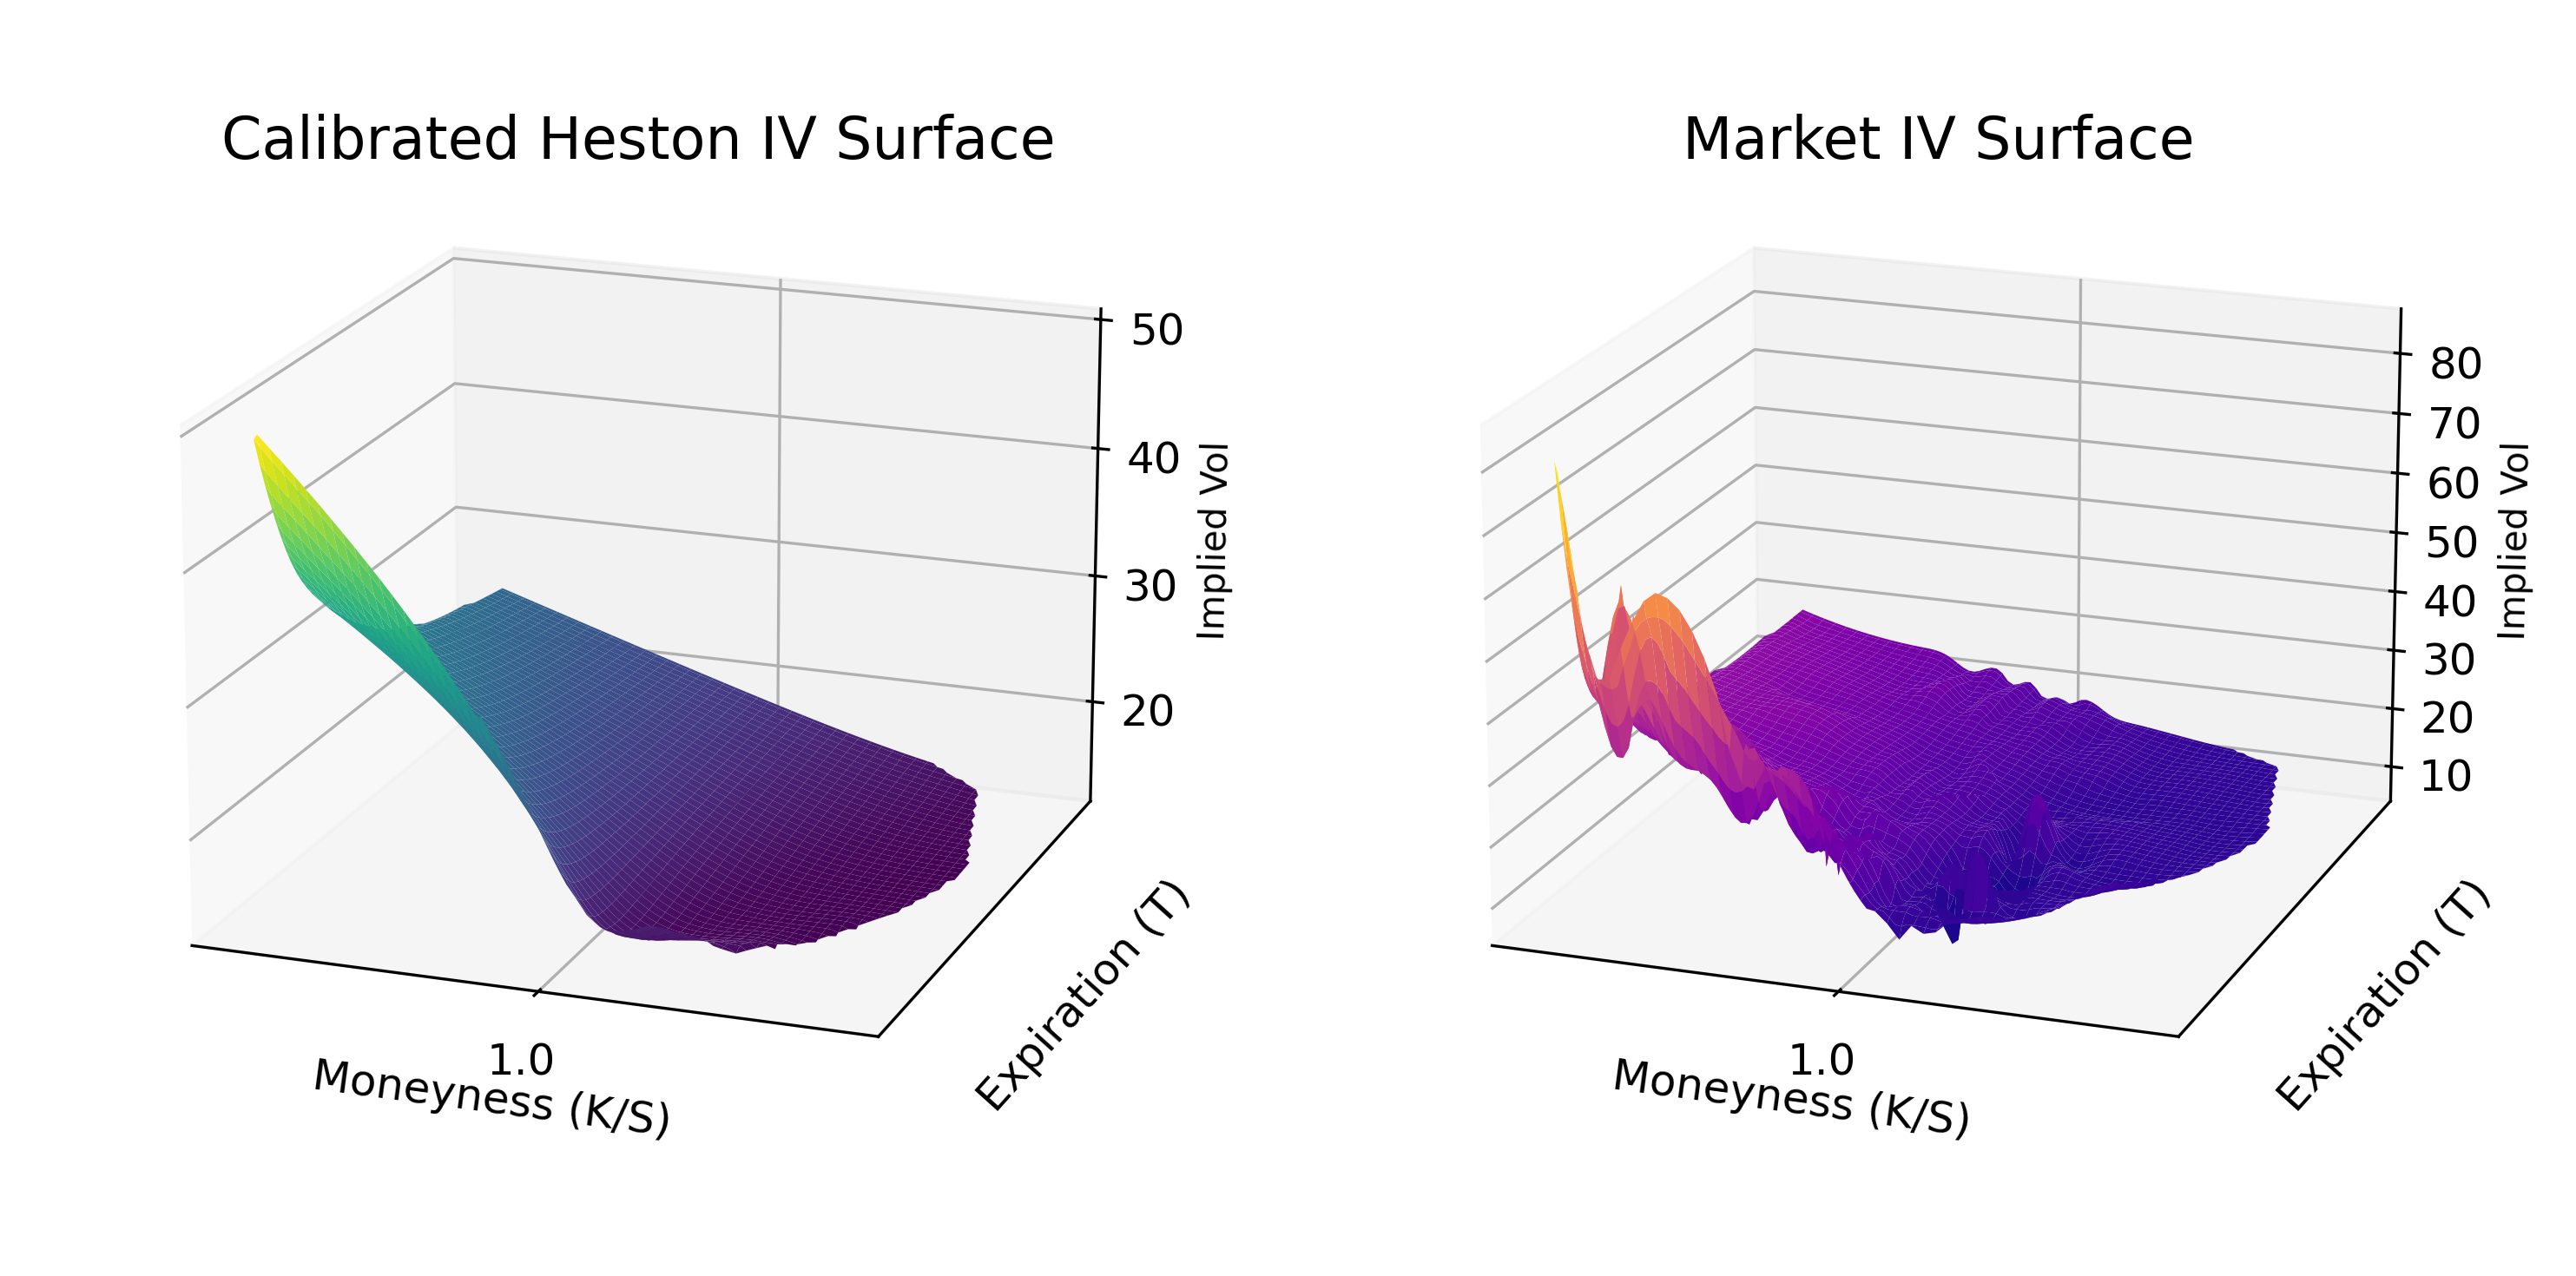

In [11]:
# 1) After your LM call, use the *filtered* Data_calib attributes:
K_cal  = Data_calib.K
T_cal  = Data_calib.T
r_cal  = Data_calib.r
q_cal  = Data_calib.q
flag_cal = Data_calib.flag

# 2) Recompute model prices on exactly those same points:
heston_prices = heston_cosine_method(
    Data_calib.S,
    K_cal,
    T_cal,
    N, L,
    r_cal,
    q_cal,
    calib_params[0,0],  # vbar
    calib_params[4,0],  # v0
    calib_params[1,0],  # sigma
    calib_params[2,0],  # rho
    calib_params[3,0],  # kappa
    flag_cal
)

# 3) Compute implied vols, flatten to 1D:
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv
calibrated_iv = calculate_iv(
    heston_prices,
    Data_calib.S,
    K_cal,
    T_cal,
    r_cal,
    flag_cal,
    q_cal,
    model='black_scholes_merton',
    return_as='numpy'
) * 100
calibrated_iv = calibrated_iv.ravel()  # make it a (N,) array

# 4) Now this will line up:
assert calibrated_iv.shape == K_cal.shape

# 5) And finally call the plot routine:
Data_calib.plot_save_surface(calibrated_iv, date_today='2024-01-02')
